In [3]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [5]:
#adding here ROI
emin = 1.5
emax = 1.7

In [7]:
# list of all files in a folder
folder_path = '../LPR_rerun/PORT_1a/prod/isaura/'
#file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# NOTE Break this section up, its annoying like this.
dfs = []
df_trs = []
df_ems = []
# create massive dataframe with all of them
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_trs.append(df_ps)
    df_ems.append(df_em)

tracks = pd.concat(dfs, axis=0, ignore_index=True)

particles = pd.concat(df_trs, ignore_index=True)
eventmap = pd.concat([dt for dt in df_ems])
# create particle list also


In [5]:
#test_df = pd.read_hdf(f'LPR/208Tl/PORT_2a/prod/isaura/isaura/isaura_10_208Tl.h5', 'MC/particles')
#display(test_df)
#test_df_2 = pd.read_hdf(f'LPR/208Tl/PORT_2a/prod/isaura/isaura/isaura_11_208Tl.h5', 'MC/particles')
#display(test_df_2)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,90000,1,Tl208,True,0,393.758881,399.115204,1122.841309,0.000000,393.758881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,90000,4,e-,False,1,393.758881,399.115204,1122.841309,0.001676,393.763916,...,0.342279,0.464510,-0.294429,-0.000000,0.000000,-0.000000,0.314066,0.208681,RadioactiveDecay,eIoni
2,90000,3,anti_nu_e,False,1,393.758881,399.115204,1122.841309,0.001676,12500.000000,...,1.445269,-0.331777,0.112124,1.445269,-0.331777,0.112124,1.487095,12456.590820,RadioactiveDecay,Transportation
3,90000,2,Pb208[3197.711],False,1,393.758881,399.115204,1122.841309,0.001676,393.758881,...,-1.787546,-0.132733,0.182304,-0.000000,-0.000000,0.000000,0.000008,0.000000,RadioactiveDecay,RadioactiveDecay
4,90000,6,gamma,False,2,393.758881,399.115204,1122.841309,0.001676,18.847403,...,-0.087256,-0.295655,-0.495059,0.000000,0.000000,0.000000,0.583188,1856.417236,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19689,90251,74,e-,False,72,340.176361,383.813110,939.066040,1.472487,340.176361,...,-0.023356,0.057056,-0.066062,-0.000000,0.000000,-0.000000,0.007928,0.000293,phot,eIoni
19690,90251,71,e-,False,68,340.166718,383.812439,939.077637,1.472437,340.163116,...,-0.386490,0.084027,0.089866,-0.000000,0.000000,-0.000000,0.141405,0.050387,phot,eIoni
19691,90251,70,e-,False,68,335.183533,369.397522,920.823242,1.393090,335.169098,...,0.007479,-0.054264,-0.390651,0.000000,0.000000,-0.000000,0.134546,0.265549,compt,eIoni
19692,90251,67,e-,False,49,290.202576,374.943085,1115.416382,0.581104,290.183624,...,0.102164,-0.022538,-0.099889,-0.000000,0.000000,-0.000000,0.020079,0.590546,eIoni,eIoni


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,100000,1,Tl208,True,0,398.613922,397.270813,1125.552124,0.000000,398.613922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,100000,4,e-,False,1,398.613922,397.270813,1125.552124,0.001589,399.848969,...,0.617923,-0.008038,1.586965,0.000000,-0.000000,-0.000000,1.267054,3.461124,RadioactiveDecay,eIoni
2,100000,3,anti_nu_e,False,1,398.613922,397.270813,1125.552124,0.001589,-6253.268066,...,-0.105869,0.087638,-0.216859,-0.105869,0.087638,-0.216859,0.256742,16131.452148,RadioactiveDecay,Transportation
3,100000,2,Pb208[3475.078],False,1,398.613922,397.270813,1125.552124,0.001589,398.613922,...,-0.512054,-0.079600,-1.370106,-0.000000,-0.000000,-0.000000,0.000006,0.000000,RadioactiveDecay,RadioactiveDecay
4,100000,6,gamma,False,2,398.613922,397.270813,1125.552124,0.001589,413.575165,...,0.124010,-0.227707,0.098506,-0.000000,-0.000000,-0.000000,0.277367,46.273708,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20589,100251,35,e-,False,17,-140.062927,118.088539,806.616028,2.700916,-139.040771,...,0.201065,0.034490,-0.187937,0.000000,0.000000,-0.000000,0.070428,3.435234,eIoni,eIoni
20590,100251,59,e-,False,35,-138.944397,118.623299,806.557434,2.712435,-138.934723,...,0.072848,0.100475,0.034624,0.000000,0.000000,-0.000000,0.015993,0.502547,eIoni,eIoni
20591,100251,34,e-,False,17,-150.033966,86.627052,833.646484,2.499939,-150.104050,...,0.118734,0.284171,-0.082528,-0.000000,0.000000,-0.000000,0.091315,5.534643,eIoni,eIoni
20592,100251,33,e-,False,17,-120.847519,61.776512,902.281494,2.219788,-120.434441,...,0.246011,0.018927,-0.153810,0.000000,0.000000,-0.000000,0.076927,6.395443,eIoni,eIoni


In [8]:
display(particles)
display(eventmap)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,2540000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,2540000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,2540000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,2540000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,2540000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041796,2030356,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.000000,0.000000,0.000000,0.025482,1.436975,eIoni,eIoni
8041797,2030356,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.000000,-0.000000,-0.000000,0.037231,2.202024,eIoni,eIoni
8041798,2030356,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.000000,0.000000,-0.000000,0.016253,0.597368,eIoni,eIoni
8041799,2030356,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.000000,0.000000,-0.000000,0.033170,1.671516,eIoni,eIoni


,evt_number
nexus_evt,
2540000,5080000
2540001,5080002
2540002,5080004
2540003,5080006
2540004,5080008
...,...
2030352,4060704
2030353,4060706
2030354,4060708


So from the event map above, the evt_number category is always double the nexus event value (weird but okay)
evt_number corresponds to tracks ``event``, while nexus_evt corresponds to particles ``event_id``

Really rogue idea, lets just double the values of event_id...


In [9]:
# double check that this is a valid solution

eventmap_reset = eventmap.reset_index()
display(eventmap_reset)

if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
    print("Falses in here!")
else:
    print("No Falses to be seen!")

# So it really is double!

,nexus_evt,evt_number
0,2540000,5080000
1,2540001,5080002
2,2540002,5080004
3,2540003,5080006
4,2540004,5080008
...,...,...
100004,2030352,4060704
100005,2030353,4060706
100006,2030354,4060708
100007,2030355,4060710


No Falses to be seen!


In [10]:
particles['event_id'] = particles['event_id'] * 2 
display(particles)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,5080000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,5080000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,5080000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,5080000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041796,4060712,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.000000,0.000000,0.000000,0.025482,1.436975,eIoni,eIoni
8041797,4060712,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.000000,-0.000000,-0.000000,0.037231,2.202024,eIoni,eIoni
8041798,4060712,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.000000,0.000000,-0.000000,0.016253,0.597368,eIoni,eIoni
8041799,4060712,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.000000,0.000000,-0.000000,0.033170,1.671516,eIoni,eIoni


##### Loading file

Lets try and load the magical file in, usually I'd use h5py but not here because IC doesn't.

The different outputs can be read about [here](https://next-exp-sw.readthedocs.io/en/latest/isaura.html).

In [9]:
#tracks = dstio.load_dst(file, 'Tracking', 'Tracks')
#evts = dstio.load_dst(file, 'Summary', 'Events')
#pen_out = dstio.load_dst(file, 'DST', 'Events')
#hit_flag = dstio.load_dst(file, 'Filters', 'hits_select')
#top_flag = dstio.load_dst(file, 'Filters', 'topology_select')
print(len(tracks))

192689


In [11]:
display(tracks)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.039447,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
4,5080002,0,0.962756,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328458,4060710,0,0.572125,48.927675,59,7484,1,314.675,294.675,522.397217,...,525.821166,349.089849,320.664750,551.769409,0.235944,0.037322,0.000000,9.833333,9.428571,4.456444
328459,4060712,0,0.861342,87.723252,103,6380,4,5.675,415.675,335.498718,...,338.256397,25.904968,465.826742,400.302053,0.169192,0.042754,0.000000,9.500000,8.875000,4.836665
328460,4060712,1,0.026480,4.836665,2,79,4,22.675,478.675,414.213104,...,416.042900,24.629322,478.906839,420.872278,0.026480,0.026480,0.026480,9.500000,8.875000,4.836665
328461,4060712,2,0.001016,8.875000,2,28,4,-6.325,440.675,354.365692,...,354.365692,-3.942128,443.310643,354.365692,0.001016,0.001016,0.001016,9.500000,8.875000,4.836665


In [11]:
#evts.head()

In [12]:
#pen_out.head()

In [13]:
#hit_flag.head()

In [14]:
#top_flag.head()

##### So I'm pretty sure we care about the tracks rather than the rest of the stuff, lets look at it and compare to beersheba.

In [12]:
#tracks.head(20)
display(tracks)
# so you can see here that the events with one track are
# 360000, 360002, 360012, etc

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.039447,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
4,5080002,0,0.962756,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328458,4060710,0,0.572125,48.927675,59,7484,1,314.675,294.675,522.397217,...,525.821166,349.089849,320.664750,551.769409,0.235944,0.037322,0.000000,9.833333,9.428571,4.456444
328459,4060712,0,0.861342,87.723252,103,6380,4,5.675,415.675,335.498718,...,338.256397,25.904968,465.826742,400.302053,0.169192,0.042754,0.000000,9.500000,8.875000,4.836665
328460,4060712,1,0.026480,4.836665,2,79,4,22.675,478.675,414.213104,...,416.042900,24.629322,478.906839,420.872278,0.026480,0.026480,0.026480,9.500000,8.875000,4.836665
328461,4060712,2,0.001016,8.875000,2,28,4,-6.325,440.675,354.365692,...,354.365692,-3.942128,443.310643,354.365692,0.001016,0.001016,0.001016,9.500000,8.875000,4.836665


In [13]:
# select a specific event
n = 2
evnt = tracks.event.unique()[n]
print("Event of interest: {}".format(evnt))

trk = tracks[tracks.event==evnt]
trk.head()

Event of interest: 5080004


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
13,5080004,0,0.475175,32.04773,19,4159,4,12.675,-316.325,147.604263,...,154.888442,26.338924,-287.808455,155.155294,0.392980,0.362969,0.280775,10.0,9.222222,4.83697
14,5080004,1,0.000826,0.00000,1,28,4,36.675,-259.325,154.847458,...,154.847458,38.559927,-256.434284,154.847458,0.000826,0.000826,0.000826,10.0,9.222222,4.83697
15,5080004,2,0.000476,0.00000,1,21,4,22.675,-336.325,159.047852,...,159.047852,24.360200,-334.110790,159.047852,0.000476,0.000476,0.000476,10.0,9.222222,4.83697
16,5080004,3,0.000204,0.00000,1,12,4,69.675,-285.325,153.809357,...,153.809357,71.210282,-284.312488,153.809357,0.000204,0.000204,0.000204,10.0,9.222222,4.83697


In [14]:
# look at all the columns
col_titles = tracks.columns.tolist()
clean_output = "\n".join(col_titles)
print(clean_output)

event
trackID
energy
length
numb_of_voxels
numb_of_hits
numb_of_tracks
x_min
y_min
z_min
r_min
x_max
y_max
z_max
r_max
x_ave
y_ave
z_ave
r_ave
extreme1_x
extreme1_y
extreme1_z
extreme2_x
extreme2_y
extreme2_z
blob1_x
blob1_y
blob1_z
blob2_x
blob2_y
blob2_z
eblob1
eblob2
ovlp_blob_energy
vox_size_x
vox_size_y
vox_size_z


### Before applying cuts, look at track energies against number of tracks as 2D histograms

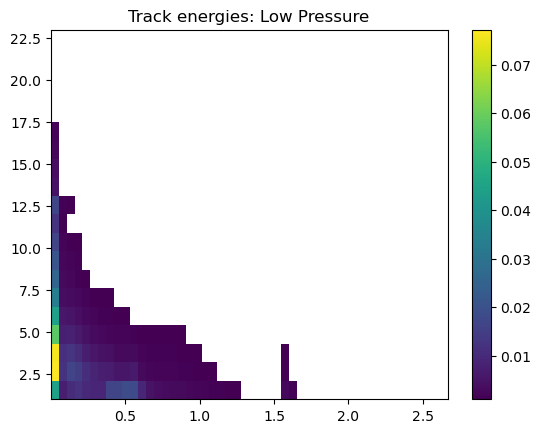

In [15]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = tracks.energy
track_no = tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(50, 20), cmin=0.001)
plt.title("Track energies: Low Pressure")
plt.colorbar()

##### Cuts

We want to:
- Include events within the fiducial volume [r < 472mm; 20 mm < z < 1195mm]
- only include 1-track events
- No overlapping blobs
- Energy cut for thallium [1.5, 1.7] MeV

In [16]:
def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency


In [17]:
def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return

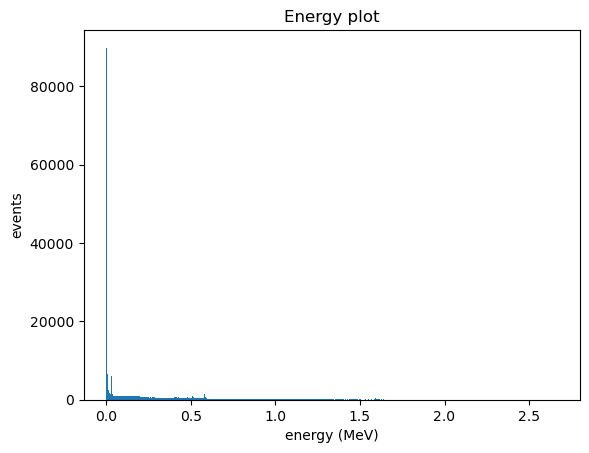

In [18]:
# plot the energy
plot_hist(tracks, binning = 1000)

In [23]:
# testing gth_lth_cuts logic
display(tracks.head())
# we'll remove event 360004 trackID 1 by applying cut < 22mm for xmin
display((tracks[(abs(tracks['x_min']) >= 22)]).head())
print("Are arrays the same length with this cut applied?")
print(len((tracks[(abs(tracks['x_min']) >= 22)])) == len(tracks))
print("How about with a 0 cut?")
print(len((tracks[(abs(tracks['x_min']) >= 0)])) == len(tracks))
print("Checks out")

# but we care about radius, need to check if radius is ever negative.
print((tracks['r_max'] <= 0))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,0.391336,28.808119,23,2652,3,-79.325,-83.325,852.084778,...,863.799393,-73.074280,-61.568806,857.545080,0.373188,0.333119,0.314971,9.97619,9.791667,4.951130
1,5080000,1,0.240723,16.088367,8,1225,3,40.675,132.675,1076.773438,...,1077.824286,54.286233,136.416425,1085.252837,0.240723,0.240723,0.240723,9.97619,9.791667,4.951130
2,5080000,2,0.144615,23.954785,7,862,3,314.675,103.675,721.902039,...,724.288058,318.342917,108.946760,725.014160,0.144428,0.143401,0.143214,9.97619,9.791667,4.951130
3,5080002,0,1.655023,52.022880,62,5758,1,87.675,412.675,1114.557129,...,1138.384607,116.737695,412.787548,1116.362275,0.950188,0.090829,0.000000,10.00000,8.714286,4.458588
4,5080004,0,0.512276,21.117782,11,2265,2,-139.325,-239.325,887.789185,...,902.722028,-126.470501,-225.620225,890.139240,0.512276,0.512276,0.512276,10.00000,9.800000,4.974428


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,0.391336,28.808119,23,2652,3,-79.325,-83.325,852.084778,...,863.799393,-73.074280,-61.568806,857.545080,0.373188,0.333119,0.314971,9.97619,9.791667,4.951130
1,5080000,1,0.240723,16.088367,8,1225,3,40.675,132.675,1076.773438,...,1077.824286,54.286233,136.416425,1085.252837,0.240723,0.240723,0.240723,9.97619,9.791667,4.951130
2,5080000,2,0.144615,23.954785,7,862,3,314.675,103.675,721.902039,...,724.288058,318.342917,108.946760,725.014160,0.144428,0.143401,0.143214,9.97619,9.791667,4.951130
3,5080002,0,1.655023,52.022880,62,5758,1,87.675,412.675,1114.557129,...,1138.384607,116.737695,412.787548,1116.362275,0.950188,0.090829,0.000000,10.00000,8.714286,4.458588
4,5080004,0,0.512276,21.117782,11,2265,2,-139.325,-239.325,887.789185,...,902.722028,-126.470501,-225.620225,890.139240,0.512276,0.512276,0.512276,10.00000,9.800000,4.974428


Are arrays the same length with this cut applied?
False
How about with a 0 cut?
True
Checks out
0         False
1         False
2         False
3         False
4         False
          ...  
192684    False
192685    False
192686    False
192687    False
192688    False
Name: r_max, Length: 192689, dtype: bool


In [19]:
'''def gth_lth_cuts(df, column_title, one_sided = False, lower_lim = 0, upper_lim = 0, absolute = True):
    #applies cut on column via upper and lower limits (greater than, lesser than)
    #column title for two sided should be a tuple!

    # double sided
    if (one_sided==False):
        # conditional absolute for fiducial case, so include negative values within this range.
        if (absolute == True):
            filt_df = df[(abs(df[column_title[0]]) >= lower_lim) & (abs(df[column_title[1]]) <= upper_lim)]
        else:
            filt_df = df[(df[column_title[0]] >= lower_lim) & (df[column_title[1]] <= upper_lim)]
    # one sided (lower or upper limit)
    else:
        # set greater or lesser based on lower or upper limit being 0
        print("placeholder")
'''
'''
def fiducial_track_cut(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    
    # Bespoke cutting algorithm for NEXT100 isaura which cuts for fiducial volume
    # z is contrained in a two-sided fashion (greater and less than), while R is taken not treated is one-sided.
    
    # create list of events that are outside the fiducial area
    z_df = df[(df['z_min'] <= lower_z) & (df['z_max'] >= upper_z)]
    rz_df = z_df[(z_df['r_max'] >= r_lim)]
    print(rz_df['event'])


    # z filtering
    filt_z_df = df[(df['z_min'] >= lower_z) & (df['z_max'] <= upper_z)] # mm

    # r filtering
    filt_df = filt_z_df[(filt_z_df['r_max'] <= r_lim)]

    # these two create masks, then you need to collect the events to preserve based on this.

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))

    return filt_df
'''


def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3



In [20]:
def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events

In [21]:
def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove
    

In [22]:
def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df


In [23]:
def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1


##### Now lets look at the fiducial selection parameters to get a feeling of whats going on

In [24]:
def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

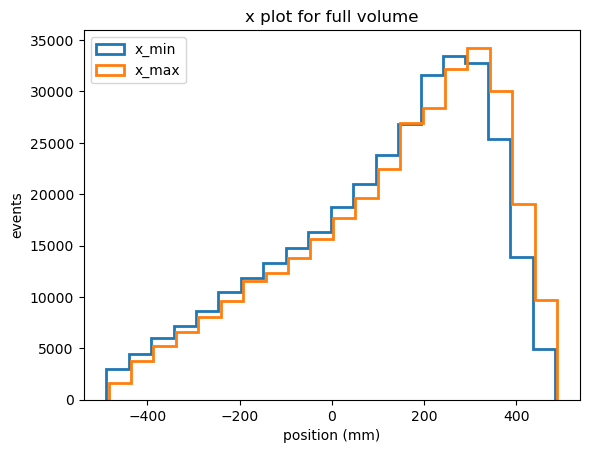

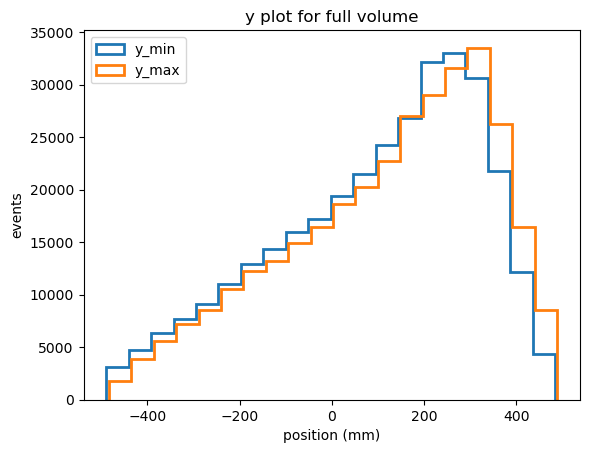

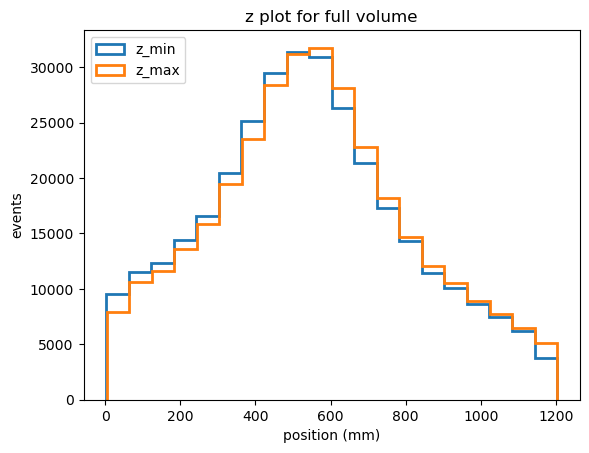

In [25]:
plot_volume_hists(tracks)

##### Considering the fiducial limits, this looks okay?
Limits:
- 20mmm < z < 1195mm
- r < 472mm (x and y limits in the -ve and negative)

Although the 472 radius seems really generous, maybe that cut has already been made? lets do a test


In [27]:
# checking what the largest x position is
x_max_max = tracks['x_max'].max()
print("Largest x_max values: {:.2f}".format(x_max_max))

Largest x_max values: 488.68


##### So this is outside the fiducial volume, this seems okay. Looking at when binning is changed from 20 -> 50, saw only artifacts in the z section.

##### So now to apply fiducial cuts

In [28]:
# for easy tracking
cut_names = []
rel_cut_effics = []
abs_cut_effics = []
cut_events = []

# no cuts
cut_names.append("No cuts")
rel_cut_effics.append(100)
abs_cut_effics.append(100)
# number of events
cut_events.append(len_events(tracks))

cut_names.append("Fiducial Cuts")

# make fiducial cuts
fiducial = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

# make efficiency calculation
ef = cut_effic(fiducial, tracks)

# add efficiency calculation
rel_cut_effics.append(ef)
cut_events.append(len_events(fiducial))
abs_cut_effics.append(ef)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Efficiency: 66.76 %


##### And the one track cut

In [29]:
# relative

cut_names.append("One track cut")
one_track_rel = one_track_cuts(fiducial, verbose = True)

# events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
one_track_abs = one_track_cuts(tracks)

## sanity check here
#print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

# relative
print("Single track cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(one_track_rel, fiducial)
rel_cut_effics.append(ef)
cut_events.append(len_events(one_track_rel))

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(one_track_abs, tracks)
abs_cut_effics.append(ef)

Removing events with more than one track.
Events with one track: Int64Index([     18,      26,      36,      62,      66,      70,      74,
                 78,      94,      98,
            ...
            5980596, 5980598, 5980608, 5980618, 5980626, 5980634, 5980638,
            5980660, 5980664, 5980670],
           dtype='int64', name='event', length=13178)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
47,5080016,0,1.116472,185.604711,197,10938,1,54.675,-3.325,88.826248,...,91.783816,75.611433,74.889792,168.354664,0.344871,0.057077,0.000000,9.777778,9.25,4.870384
75,5080036,0,1.596255,144.864878,135,11296,1,-96.325,310.675,260.970490,...,268.043679,-20.318174,405.310820,306.184504,0.699152,0.395385,0.000000,9.444444,10.00,4.818069
94,5080048,0,0.399919,37.882893,25,4441,1,261.675,-27.325,248.397156,...,254.486933,268.544232,-3.573514,256.035212,0.279063,0.231001,0.114661,9.833333,10.00,4.499156
108,5080056,0,0.549710,47.397741,64,4942,1,21.675,178.675,293.515228,...,297.218949,54.647243,200.007009,325.934815,0.487114,0.056183,0.000000,8.500000,9.00,4.845287
145,5080078,0,0.659019,48.054243,52,6645,1,215.675,117.675,433.161438,...,440.442095,264.387232,137.261074,448.476302,0.457925,0.090651,0.000000,9.250000,9.40,4.183667


Single track cut
Relative Cut efficiency:
Efficiency: 19.74 %
Absolute Cut efficiency:
Efficiency: 17.97 %


#### Plot the spacial stuff and compare

Looks good to me

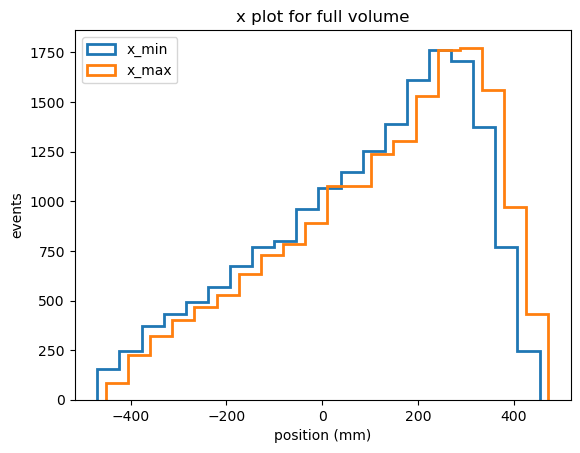

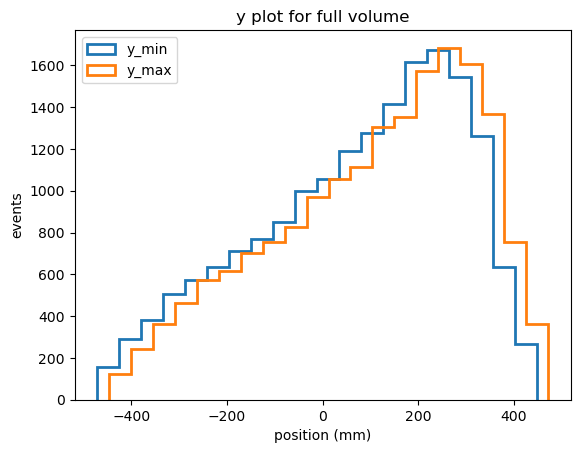

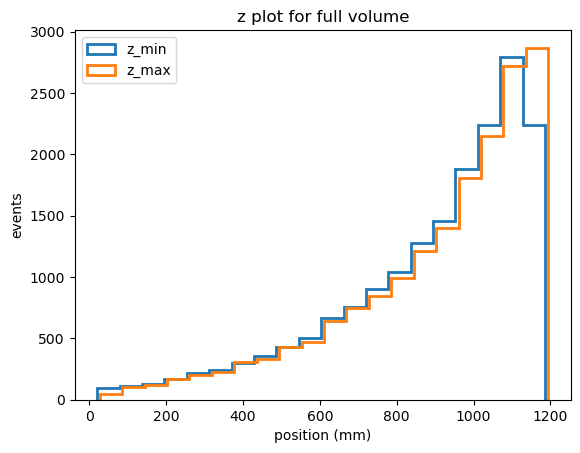

In [34]:
plot_volume_hists(one_track_rel)

#### No overlapping blobs

I have to assume this is achieved by setting ovlp_blob_energy, but lets look at these values and see if thats easy.

In [35]:
display(one_track_rel['ovlp_blob_energy'])


3         0.000000
15        0.013679
16        0.365469
17        0.506065
18        0.304488
            ...   
192613    0.584867
192647    0.372762
192654    0.000000
192665    0.513903
192677    0.277879
Name: ovlp_blob_energy, Length: 17797, dtype: float64

Seems to have a lot of values at zero, so I think this is an acceptable cut method

In [36]:
# apply cuts
ovlp_rel = overlapping_cuts(one_track_rel)
ovlp_abs = overlapping_cuts(tracks)

In [37]:
cut_names.append("Blob overlap cuts")


# relative
print("Blob overlap cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ovlp_rel, one_track_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ovlp_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ovlp_abs, tracks)
abs_cut_effics.append(ef)

Blob overlap cut
Relative Cut efficiency:
Efficiency: 25.68 %
Absolute Cut efficiency:
Efficiency: 6.44 %


#### Energy cut

Want to limit range from [1.5, 1.7] MeV

In [38]:
ecut_rel = energy_cuts(ovlp_rel)
ecut_abs = energy_cuts(tracks)

cut_names.append("Energy cuts")

# relative
print("Energy cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ecut_rel, ovlp_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ecut_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ecut_rel, tracks)
abs_cut_effics.append(ef)

Energy cut
Relative Cut efficiency:
Efficiency: 6.32 %
Absolute Cut efficiency:
Efficiency: 0.41 %


#### Print cut efficiency relative and absolute as a table and plot the energy of the final cuts

In [39]:
efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Single Cut Efficiency': abs_cut_effics,
                             'Relative Events': cut_events})

In [40]:
display(efficiencies)
# NOTE!!! THE EVENTS ARE RELATIVE. So to get the number of events by single cut,
# multiply the events against single cut efficiency

,Cut,Relative Efficiency,Single Cut Efficiency,Relative Events
0,No cuts,100.000000,100.000000,70963
1,Fiducial Cuts,73.459408,73.459408,52129
2,One track cut,34.140306,31.305046,17797
3,Blob overlap cuts,25.678485,6.439976,4570
4,Energy cuts,6.323851,0.407254,289


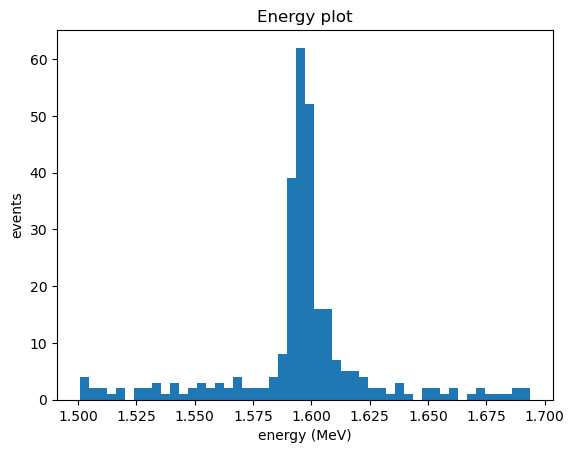

In [41]:
# plot energy of final
plot_hist(ecut_rel, binning = 50)

#### Histogram plotting showing the effect of all the cuts:

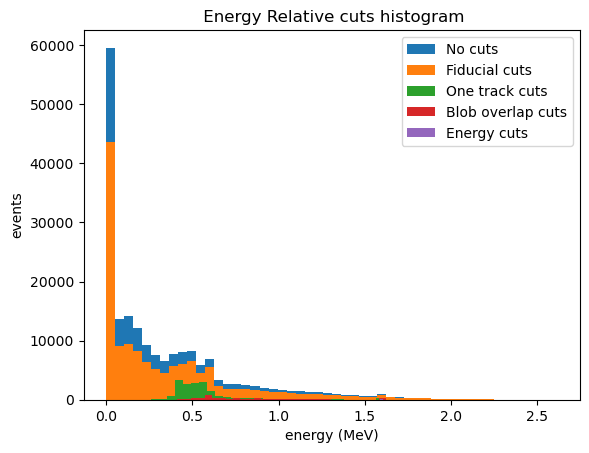

In [42]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50)
plot_hist(one_track_rel, label = 'One track cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'Blob overlap cuts', output = False, binning = 50)
plot_hist(ecut_rel, label = 'Energy cuts', output = False, title=' Energy Relative cuts histogram')
plt.legend()
plt.show()

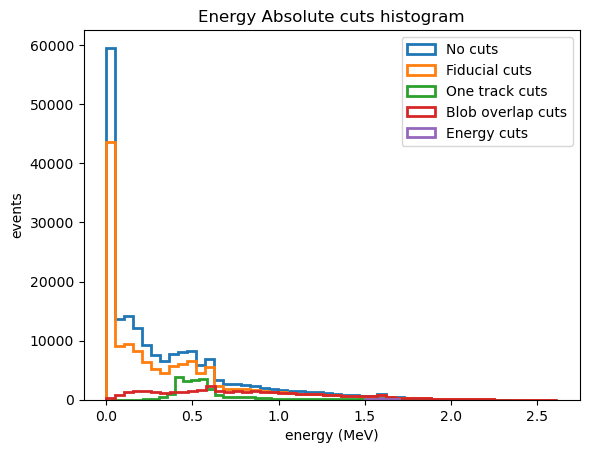

In [43]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50, fill = False)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50, fill = False)
plot_hist(one_track_abs, label = 'One track cuts', output = False, binning = 50, fill = False)
plot_hist(ovlp_abs, label = 'Blob overlap cuts', output = False, binning = 50, fill = False)
plot_hist(ecut_abs, label = 'Energy cuts', output = False, title='Energy Absolute cuts histogram', fill = False)
plt.legend()
plt.show()

##### Lets do the same but exclude the final energy cut and log it

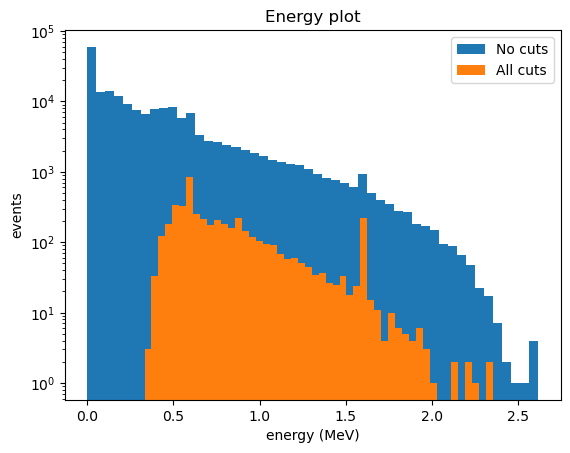

In [44]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'All cuts', output = False, binning = 50)
plt.yscale('log')
plt.legend()
plt.show()

0.013864971504759738 1.2022062931585713


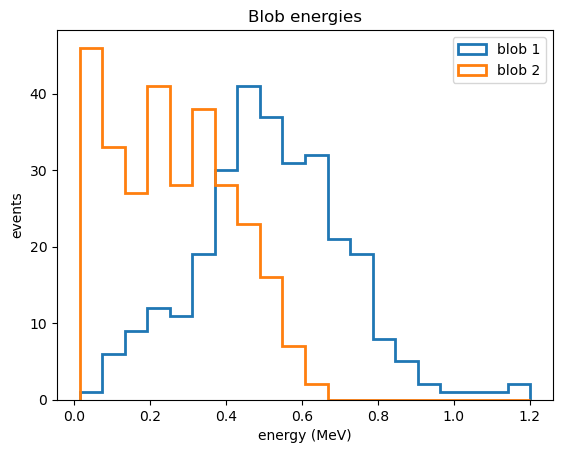

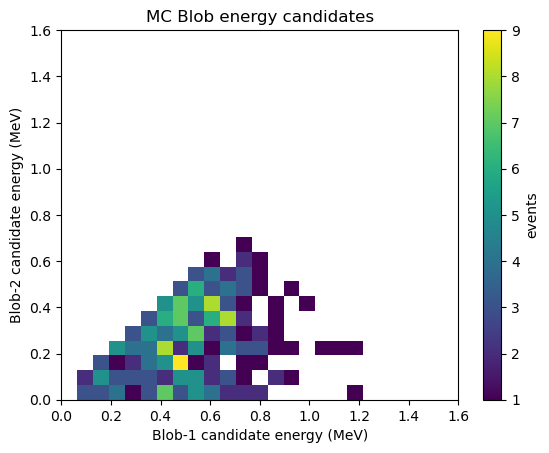

In [45]:
# produce nicer plots, this is energy histograms for the blobs post-all cuts

# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
print(minimum_e, maximum_e)

plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(ecut_rel['eblob1'], ecut_rel['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

In [46]:
display(ecut_rel)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,5080002,0,1.655023,52.022880,62,5758,1,87.675,412.675,1114.557129,...,1138.384607,116.737695,412.787548,1116.362275,0.950188,0.090829,0.0,10.000000,8.714286,4.458588
1716,3580364,0,1.593692,72.421034,101,6962,1,12.675,188.675,1122.988525,...,1125.707051,20.486813,203.555333,1163.440676,0.367297,0.258254,0.0,9.833333,9.000000,4.893975
2601,3260012,0,1.600612,173.068199,133,7141,1,96.675,-299.325,398.507111,...,423.100372,114.680619,-254.166408,463.007313,0.549444,0.279998,0.0,10.000000,9.222222,4.793878
2715,3260106,0,1.595215,70.297552,98,7422,1,-192.325,37.675,888.828430,...,915.675660,-186.849171,96.157919,915.552644,0.843625,0.213118,0.0,9.000000,9.285714,4.981316
3018,3260320,0,1.600568,187.019661,101,7188,1,-242.325,-274.325,454.153534,...,456.598826,-221.649377,-142.226550,517.030014,0.401444,0.327780,0.0,9.600000,9.666667,4.718787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189380,1200314,0,1.600732,164.730123,112,6010,1,179.675,148.675,939.244934,...,1000.061958,195.050257,225.948844,957.264772,0.559303,0.047924,0.0,9.375000,9.777778,4.720673
189802,4380122,0,1.635728,57.401797,89,7238,1,-56.325,403.675,957.104431,...,977.009949,-39.568121,408.398094,965.462219,0.267643,0.219285,0.0,9.750000,9.000000,4.657959
190351,1760054,0,1.541453,161.541857,114,6490,1,93.675,25.675,999.080139,...,1014.490770,167.879451,163.548427,1001.495297,0.690059,0.101404,0.0,9.500000,9.625000,4.341945
190632,1760266,0,1.595404,103.489807,109,6056,1,-289.325,-98.325,780.664917,...,829.246128,-285.638461,-37.997403,781.117395,0.501927,0.144715,0.0,9.428571,9.625000,4.762385


#### Playing around with MC

Want to make a plot that shows the MC background here

In [47]:
# MC stuff taken from above
display(particles)
#display(eventmap.head(5))
display(ecut_rel.head())


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080000,1,Tl208,True,0,394.379333,397.299896,1123.894287,0.000000,394.379333,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,5080000,4,e-,False,1,394.379333,397.299896,1123.894287,0.000329,397.574554,...,0.298550,-0.500215,-0.120595,0.000000,0.0000,0.000000,0.273227,6.134542,RadioactiveDecay,eIoni
2,5080000,3,anti_nu_e,False,1,394.379333,397.299896,1123.894287,0.000329,3386.472656,...,0.284348,-0.560600,1.081109,0.284348,-0.5606,1.081109,1.250569,13159.272461,RadioactiveDecay,Transportation
3,5080000,2,Pb208[3475.078],False,1,394.379333,397.299896,1123.894287,0.000329,394.379333,...,-0.582898,1.060815,-0.960514,-0.000000,0.0000,-0.000000,0.000006,0.000000,RadioactiveDecay,RadioactiveDecay
4,5080000,6,gamma,False,2,394.379333,397.299896,1123.894287,0.000329,322.789032,...,-0.678180,-0.522776,-0.085619,0.000000,-0.0000,0.000000,0.860554,1767.570312,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724192,4060470,51,e-,False,33,-52.155415,-376.568848,922.736206,3.119910,-52.155907,...,-0.014988,0.017691,0.004070,-0.000000,0.0000,0.000000,0.000542,0.002932,compt,eIoni
5724193,4060470,50,e-,False,33,-52.155415,-376.568848,922.736206,3.119910,-50.344692,...,-0.318292,-0.518366,0.062670,-0.000000,0.0000,-0.000000,0.285908,37.882458,compt,eIoni
5724194,4060470,88,e-,False,50,-53.210651,-381.387848,923.548096,3.142658,-52.953606,...,0.008486,-0.228941,0.153380,-0.000000,-0.0000,-0.000000,0.069631,6.677827,eIoni,eIoni
5724195,4060470,30,e-,False,29,396.589569,390.954346,1142.969971,0.063078,396.598022,...,-0.320552,-0.079711,0.683712,-0.000000,-0.0000,0.000000,0.404255,0.242132,conv,eIoni


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,5080002,0,1.655023,52.022880,62,5758,1,87.675,412.675,1114.557129,...,1138.384607,116.737695,412.787548,1116.362275,0.950188,0.090829,0.0,10.000000,8.714286,4.458588
1716,3580364,0,1.593692,72.421034,101,6962,1,12.675,188.675,1122.988525,...,1125.707051,20.486813,203.555333,1163.440676,0.367297,0.258254,0.0,9.833333,9.000000,4.893975
2601,3260012,0,1.600612,173.068199,133,7141,1,96.675,-299.325,398.507111,...,423.100372,114.680619,-254.166408,463.007313,0.549444,0.279998,0.0,10.000000,9.222222,4.793878
2715,3260106,0,1.595215,70.297552,98,7422,1,-192.325,37.675,888.828430,...,915.675660,-186.849171,96.157919,915.552644,0.843625,0.213118,0.0,9.000000,9.285714,4.981316
3018,3260320,0,1.600568,187.019661,101,7188,1,-242.325,-274.325,454.153534,...,456.598826,-221.649377,-142.226550,517.030014,0.401444,0.327780,0.0,9.600000,9.666667,4.718787


In [48]:
# lets look at some 'True' primary events
prim_parts = particles['primary']
print(prim_parts.any()) # checks for true, false if otherwise

True


#### So collect all the events that are e+ and plot those alongside the blob energies plot to show how much is e+e- background :)

In [49]:
# create e+ dataframe only
positron_df = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events = positron_df.append(particles.loc[condition], ignore_index=True)
display(positron_events)

# collect events
pos_events = np.unique(positron_events['event_id'].to_numpy())
print("Number of positron events: {}".format(len(pos_events)))
print(pos_events)

## remove non-unique numbers (NO NEED TO DO THIS AS THERE SHOULD ONLY BE ONE POSITRON 
##                              PER EVENT)
#unique_elements, counts = np.unique(pos_events, return_counts=True)
#unique_indices = np.where(counts ==1)[0]
#unique_events = unique_elements[unique_indices]
#print(unique_events[10:20])



,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080012,28,e+,False,26,397.994476,406.192200,1104.511230,0.081588,397.663483,...,-0.113898,0.392981,-1.828005,0.0,0.0,-0.0,1.430683,1.431519,conv,annihil
1,5080018,36,e+,False,34,417.531311,434.714142,1134.706055,0.147440,417.572449,...,1.069797,0.628779,-0.066560,-0.0,0.0,-0.0,0.832645,0.483091,conv,annihil
2,5080036,35,e+,False,33,351.407288,195.293655,1046.552856,0.731658,388.764038,...,-0.395765,-1.658938,-0.268138,-0.0,0.0,-0.0,1.289479,415.102295,conv,annihil
3,5080046,39,e+,False,37,356.425354,-46.521172,775.359009,1.884820,364.295624,...,0.227442,-0.875990,-0.139887,0.0,-0.0,-0.0,0.537704,127.085846,conv,annihil
4,5080050,73,e+,False,71,234.638184,449.706116,1324.644409,0.869903,227.466187,...,-0.485283,-0.023844,1.693891,-0.0,0.0,0.0,1.323792,9.668751,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9658,4060396,55,e+,False,53,-317.644165,122.913124,780.973267,2.805562,-227.563492,...,-1.560910,-0.481398,-0.572206,0.0,0.0,0.0,1.293640,398.153534,conv,annihil
9659,4060398,29,e+,False,27,388.389008,145.365875,1089.239014,0.848894,388.548676,...,-0.078389,-0.186970,0.119934,-0.0,-0.0,-0.0,0.051679,3.023956,conv,annihil
9660,4060434,91,e+,False,87,210.304977,-88.572311,528.882324,2.638315,209.844193,...,0.204529,-0.242675,-0.472967,0.0,0.0,0.0,0.254208,50.648548,conv,annihil
9661,4060456,34,e+,False,32,366.878693,391.280914,1094.120483,0.133110,365.349640,...,-0.834090,-0.260838,-0.929550,0.0,-0.0,-0.0,0.863383,4.327487,conv,annihil


Number of positron events: 9662
[26 36 54 ... 5980390 5980396 5980406]


In [50]:
# collect all events that match this list
ecut_no_positron_df = ecut_rel[~ecut_rel['event'].isin(pos_events)]

display(ecut_no_positron_df)

# events with positrons only in here!
ecut_positron_df = ecut_rel[ecut_rel['event'].isin(pos_events)]

display(ecut_positron_df)

# Check that we get all the data, should print true (which it does) 
print(len(ecut_positron_df) + len(ecut_no_positron_df) == len(ecut_rel))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,5080002,0,1.655023,52.022880,62,5758,1,87.675,412.675,1114.557129,...,1138.384607,116.737695,412.787548,1116.362275,0.950188,0.090829,0.0,10.000000,8.714286,4.458588
5124,3900420,0,1.689774,160.336061,116,6433,1,-46.325,-153.325,751.298706,...,794.724386,64.777887,-131.075603,753.975622,0.576319,0.390139,0.0,9.833333,10.000000,4.716803
12361,3560452,0,1.667815,237.092209,140,6815,1,-81.325,88.675,309.259155,...,332.699973,-50.792647,94.950329,312.059043,0.518023,0.461178,0.0,9.181818,9.619048,4.979492
15130,2820472,0,1.688255,158.369148,121,6397,1,-207.325,-143.325,803.789429,...,849.873150,-200.347325,-108.656164,806.347796,0.506423,0.378851,0.0,9.500000,9.833333,4.824060
27237,1580190,0,1.575490,66.666093,82,6340,1,370.675,112.675,1029.529907,...,1031.100763,393.622957,120.245676,1070.911892,0.702632,0.027916,0.0,9.571429,9.250000,4.721570
28742,4440288,0,1.585606,129.735595,131,6892,1,181.675,277.675,965.492371,...,1009.612375,293.659898,340.660900,971.773421,0.141750,0.061539,0.0,9.857143,9.250000,4.825879
31430,3000318,0,1.511211,150.454731,117,6882,1,-51.325,-129.325,133.894577,...,224.918939,-20.175422,-123.711659,136.313237,0.357297,0.314585,0.0,9.333333,9.333333,4.967513
37168,3820230,0,1.553783,178.617231,152,6116,1,-131.325,-287.325,574.879883,...,665.458942,-125.249279,-271.710682,583.782882,0.639966,0.026817,0.0,9.142857,9.250000,4.915402
42582,1040182,0,1.500601,154.478904,142,6596,1,142.675,178.675,1109.331421,...,1148.778648,210.055599,317.246745,1129.807692,0.131814,0.013865,0.0,9.454545,10.000000,4.662774
51818,1680170,0,1.649399,183.136953,149,6876,1,91.675,-304.325,76.184998,...,79.095308,209.553570,-287.402816,154.390233,0.557161,0.109079,0.0,9.846154,9.700000,4.749381


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
1716,3580364,0,1.593692,72.421034,101,6962,1,12.675,188.675,1122.988525,...,1125.707051,20.486813,203.555333,1163.440676,0.367297,0.258254,0.0,9.833333,9.000000,4.893975
2601,3260012,0,1.600612,173.068199,133,7141,1,96.675,-299.325,398.507111,...,423.100372,114.680619,-254.166408,463.007313,0.549444,0.279998,0.0,10.000000,9.222222,4.793878
2715,3260106,0,1.595215,70.297552,98,7422,1,-192.325,37.675,888.828430,...,915.675660,-186.849171,96.157919,915.552644,0.843625,0.213118,0.0,9.000000,9.285714,4.981316
3018,3260320,0,1.600568,187.019661,101,7188,1,-242.325,-274.325,454.153534,...,456.598826,-221.649377,-142.226550,517.030014,0.401444,0.327780,0.0,9.600000,9.666667,4.718787
3608,80316,0,1.598567,146.093980,128,6466,1,-282.325,167.675,857.340576,...,881.248188,-212.238441,265.186644,884.164284,0.541096,0.276916,0.0,9.600000,9.363636,4.585632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189330,1200264,0,1.605276,163.726878,140,6621,1,177.675,209.675,962.342041,...,996.595706,181.212438,220.801557,996.922022,0.810095,0.130806,0.0,9.454545,9.533333,4.720154
189380,1200314,0,1.600732,164.730123,112,6010,1,179.675,148.675,939.244934,...,1000.061958,195.050257,225.948844,957.264772,0.559303,0.047924,0.0,9.375000,9.777778,4.720673
189802,4380122,0,1.635728,57.401797,89,7238,1,-56.325,403.675,957.104431,...,977.009949,-39.568121,408.398094,965.462219,0.267643,0.219285,0.0,9.750000,9.000000,4.657959
190632,1760266,0,1.595404,103.489807,109,6056,1,-289.325,-98.325,780.664917,...,829.246128,-285.638461,-37.997403,781.117395,0.501927,0.144715,0.0,9.428571,9.625000,4.762385


True


In [51]:
'''
# trying the same thing again but with Helenas method?
withpositron_list = particles[particles['particle_name'] == 'e+']['event_id'].unique()
event_nopos_sel = ecut_rel.event.isin(withpositron_list)

ecut_rel_withpos = ecut_rel[event_nopos_sel]

display(ecut_rel_withpos)

# stolen from Helena's code, will understand it better once I get it to work
# i dont need to understand it, as my code works fine without this. Can remove if wanted

no_pos_blob1 = []
no_pos_blob2 = []
no_pos_e = []


for evt in ecut_rel.event.unique():
    ecut_rel_evt = ecut_rel[ecut_rel.event == evt]

    posi_evt = ecut_rel_withpos[ecut_rel_withpos.event == evt]
    try:
        print("Positron")
        posi_evt.x_min.values[0]
    except:
        print('no positron')
        no_pos_blob1.append(ecut_rel_evt.eblob1.values[0])
        no_pos_blob2.append(ecut_rel_evt.eblob2.values[0])
        no_pos_e.append(ecut_rel_evt.energy.values[0])

# produce nicer plots, this is energy histograms for the blobs post-all cuts


plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

#plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
#plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

'''

'\n# trying the same thing again but with Helenas method?\nwithpositron_list = particles[particles[\'particle_name\'] == \'e+\'][\'event_id\'].unique()\nevent_nopos_sel = ecut_rel.event.isin(withpositron_list)\n\necut_rel_withpos = ecut_rel[event_nopos_sel]\n\ndisplay(ecut_rel_withpos)\n\n# stolen from Helena\'s code, will understand it better once I get it to work\n# i dont need to understand it, as my code works fine without this. Can remove if wanted\n\nno_pos_blob1 = []\nno_pos_blob2 = []\nno_pos_e = []\n\n\nfor evt in ecut_rel.event.unique():\n    ecut_rel_evt = ecut_rel[ecut_rel.event == evt]\n\n    posi_evt = ecut_rel_withpos[ecut_rel_withpos.event == evt]\n    try:\n        print("Positron")\n        posi_evt.x_min.values[0]\n    except:\n        print(\'no positron\')\n        no_pos_blob1.append(ecut_rel_evt.eblob1.values[0])\n        no_pos_blob2.append(ecut_rel_evt.eblob2.values[0])\n        no_pos_e.append(ecut_rel_evt.energy.values[0])\n\n# produce nicer plots, this is en

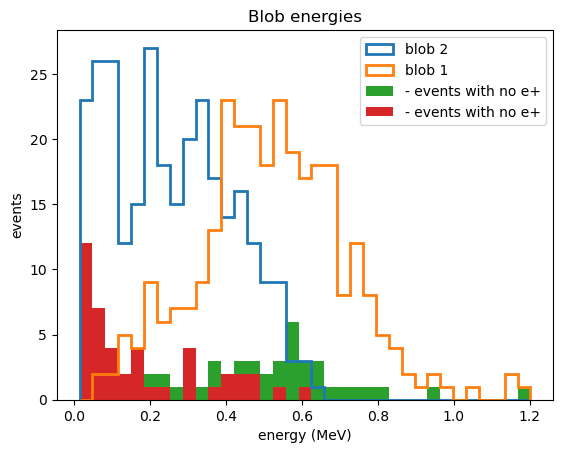

In [58]:
these_bins = 35
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_no_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_no_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()


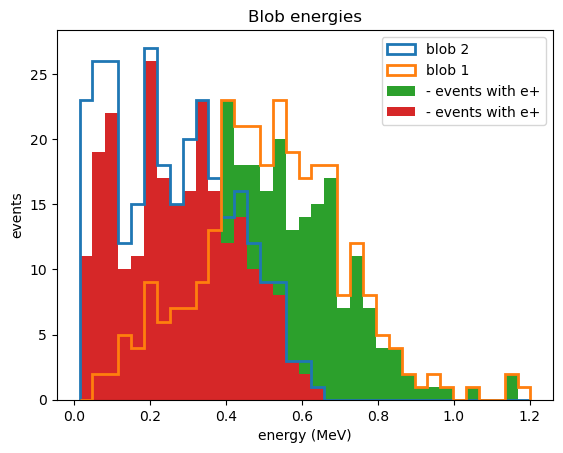

In [59]:
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()


Trying this now with the energy only

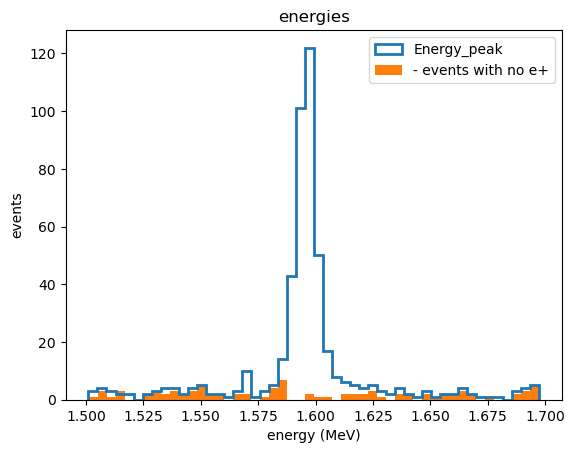

In [54]:
plot_hist(ecut_rel, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = 'Energy_peak', x_label = 'energy (MeV)')
plot_hist(ecut_no_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)')

plt.legend()
plt.show()

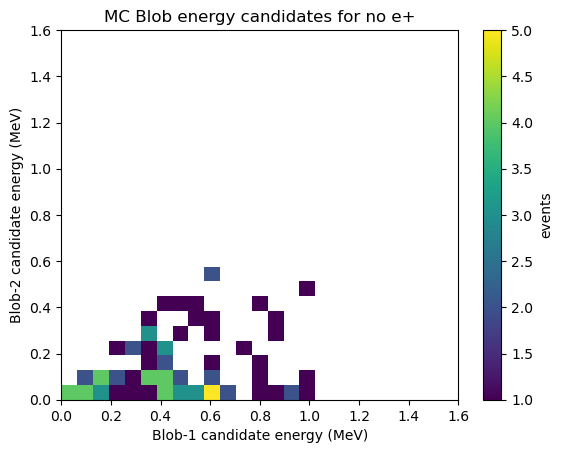

In [55]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_no_positron_df['eblob1'], ecut_no_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for no e+")
plt.show()

#### Apply the fitting to our energy cuts



In [56]:
# lets try this ourselves

def bck_func(x, nb, tau):
    '''
    Function describing the background, an exponential with scaling from Nb and tau
    '''

    return nb*np.exp(-x/tau)

def skewnorm_func(x, a, mu, sigma):
    return skewnorm.pdf(x, a, loc = mu, scale = sigma)

def error_func(x, mu, sigma):
    pas = (x - mu)/(np.sqrt(2)*sigma)
    return special.erfc(pas)


def sig_func(x, ns, a, mu, sigma, C1, C2):
    
    return ns * (skewnorm_func(x, a, mu, sigma) + C1*error_func(x, mu, sigma) + C2)

def sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau):

    return bck_func(x, nb, tau) + sig_func(x, ns, a, mu, sigma, C1, C2)

In [ ]:
# plot both signal and background functions at specific parameters, for sanity
big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2', 'nb', 'tau']
p123 = ([2, -2.8, 1.58, 0.006, 0.0003, 0.0001, 300, 300])

x = np.linspace(1.5,1.7, 10000)
y_sig = sig_func(x, *p123[:-2])
plt.title("Signal function")
plt.plot(x,y_sig)
plt.show()
print(p123[-2:])

y_bck = bck_func(x, *p123[-2:])
plt.title("Background function")
plt.plot(x,y_bck)
plt.show()

y_sig_bck = sig_bck_func(x, *p123)
plt.title("Sig+bck function")
plt.plot(x,y_sig_bck)
plt.show()


In [56]:
# create gaussian initially for testing purposes
def gauss(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return a*np.exp(-numer/denom)




In [57]:
# and a print function
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0


# plot parameters for fit, similar to plot_hist
def plot_fit(function, x, popt, popt_label, output = False, colour = 'red', x_counts = 100000, lgnd = 'Fit'):
    '''
    plots a fit based on individual points and a function
    plots across a more continuous space, to reduce weird artifacting for low X numbers
    '''

    # take much more continuous x axis
    x_min = np.min(x)
    x_max = np.max(x)

    x_plot = np.linspace(x_min, x_max, num = x_counts, endpoint = True)

    y = function(x_plot, *popt)
    plt.plot(x_plot, y, label = lgnd, color = colour)
    for i in range(len(popt)):

        plt.text(1.5, 500 - 25*i, str(popt_label[i]) + ": " + str(round(popt[i], 5)))

    if (output == True):
        plt.show()
    else:
        return


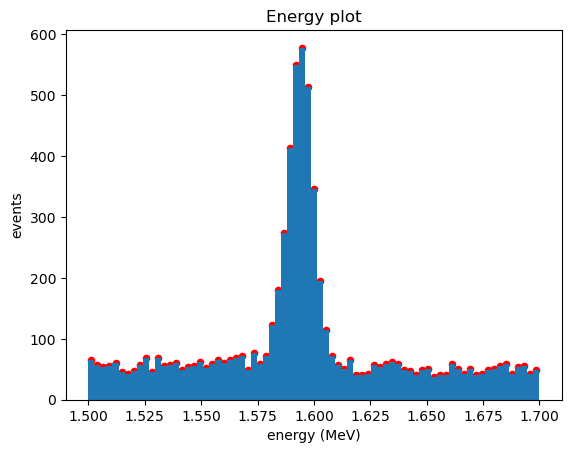

In [58]:
# try fitting gaussian
evalues = ecut_rel['energy'].to_numpy()

e_low = np.min(evalues) 
e_high = np.max(evalues)

# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 75, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)

plt.scatter(centres, hist, color='red', s = 20)
plt.show()

In [59]:
# fit gaussian to this

# p0 is the initial guesses
p0 = ([800, 1.58, 0.04])
gauss_labels = ['a', 'mu','sigma']

popt, pcov = curve_fit(gauss, centres, hist, p0, maxfev = 500000)


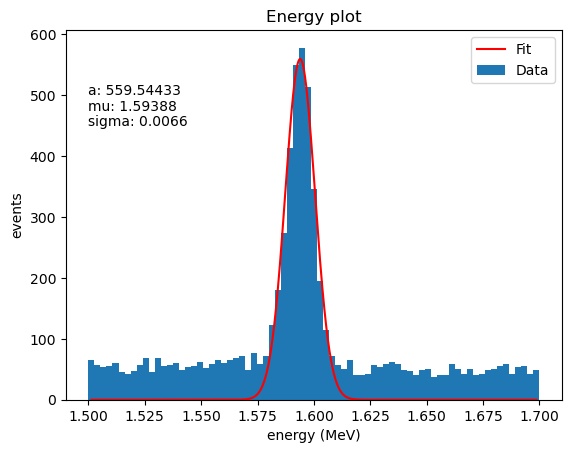

        Fitting output      
a: 559.5443 ± 29.7872
mu: 1.5939 ± 0.0004
sigma: 0.0066 ± 0.0004


0

In [60]:
plot_fit(gauss, centres, popt, gauss_labels)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_labels)

#### Fit with the full fat thing now

In [61]:
# fit full thing to this

# ns -> take as fraction of peak. Example: peak at 1000 events, ns at 1000*8

# p0 is the initial guesses
p1 = ([6400, -2.8, 1.58, 0.006, 0.0003, 0.0001, 3500, 300])
big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2', 'nb', 'tau']

popt, pcov = curve_fit(sig_bck_func, centres, hist, p1, maxfev = 500000)

In [62]:
print(big_labels[:-2])

['ns', 'a', 'mu', 'sigma', 'C1', 'C2']


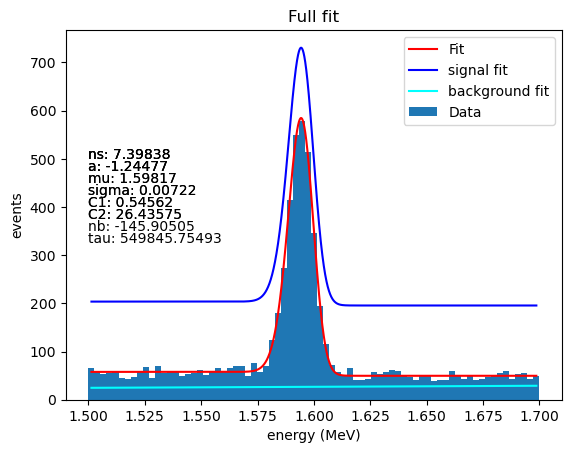

        Fitting output      
ns: 7.3984 ± nan
a: -1.2448 ± 0.1412
mu: 1.5982 ± 0.0002
sigma: 0.0072 ± 0.0002
C1: 0.5456 ± 0.3512
C2: 26.4357 ± nan
nb: -145.9051 ± nan
tau: 549845.7549 ± nan


/tmp/ipykernel_11038/3172978394.py:14: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


0

In [63]:
plot_fit(sig_bck_func, centres, popt, big_labels)
plot_fit(sig_func, centres, popt[:-2], big_labels[:-2], lgnd='signal fit', colour = 'blue')
plot_fit(bck_func, centres, popt[:2], big_labels[:2], lgnd='background fit', colour = 'cyan')
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()
print_parameters(popt, pcov, big_labels)

#### Create fom for blob 2 cuts

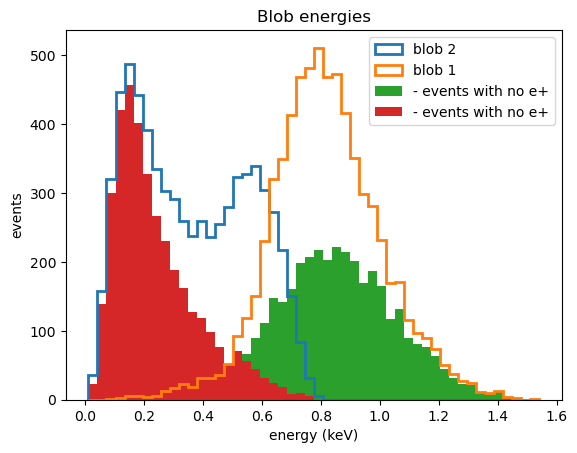

In [67]:
def blob_positron_plot(ecut_rel, ecut_no_positron_df, save = False, save_title = 'plot.png'):
    '''
    Plots the blob energies with and without positrons.
    '''

    # the original way
    plot_hist(ecut_rel, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_rel, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    #plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
    #plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

    plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    plt.legend()

    if (save == True):
        plt.savefig(save_title)
    plt.show()

blob_positron_plot(ecut_rel, ecut_no_positron_df)

In [99]:
def default_fit(data, bins = 75, verbose = False):
    '''
    Apply the expected fit to the data here,
    '''

    # find minima and maxima
    evalues = data['energy'].to_numpy()
    e_low = np.min(evalues) 
    e_high = np.max(evalues)

    # collect heights from histogram of energy
    hist, edges, patches = plot_hist(data, binning = bins, output = False, data = True)
    # convert edges to centres
    centres = shift_to_bin_centers(edges)


    # collect assumptions
    p1 = ([6400, -2.8, 1.58, 0.006, 0.0003, 0.0001, 3500, 300])
    big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2', 'nb', 'tau']

    # fit function
    popt, pcov = curve_fit(sig_bck_func, centres, hist, p1, maxfev = 1000000)

    if (verbose == True):
        plot_fit(sig_bck_func, centres, popt, big_labels)
        plot_fit(sig_func, centres, popt[:-2], big_labels[:-2], lgnd='signal fit', colour = 'blue')
        plot_fit(bck_func, centres, popt[:2], big_labels[:2], lgnd='background fit', colour = 'cyan')
        plot_hist(ecut_rel, binning = bins, output = False, data = True, label='Data', title='Full fit')
        plt.legend()
        plt.show()
        print_parameters(popt, pcov, big_labels)
    
    # return ns and nb calculations
    ns = popt[0]
    nb = popt[-2]

    return (ns, nb)
        



def fom_calc(data, no_pos_data, cut_list, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    '''

    if (verbose == True):
        blob_positron_plot(data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    output = default_fit(data, verbose = True)
    ns0 = output[0]
    nb0 = output[1]
    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        
        # remove blob 2 values below value on cut_list
        data = data[(data['eblob2'] > cut_list[i])]
        no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]
        # apply fit to the new data 
        if (verbose == True):
            output = default_fit(data, verbose = True)
        else:
            output = default_fit(data, verbose = False)
        ns = output[0]
        nb = output[1]

        # produce fom value
        e.append(ns/ns0)
        b.append(nb/nb0)
        fom.append(e[i]/np.sqrt(b[i]))

        if (verbose == True):
            blob_positron_plot(data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom






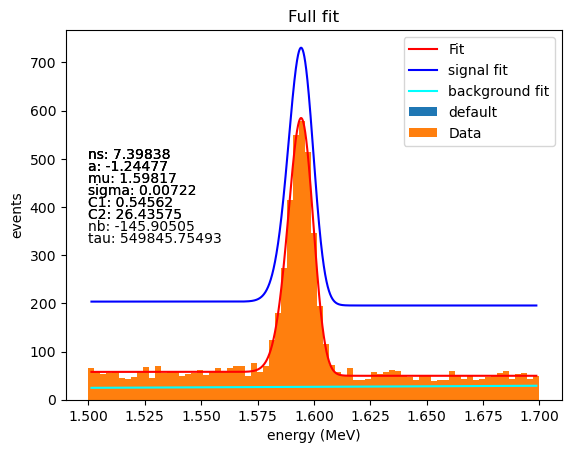

        Fitting output      
ns: 7.3984 ± nan
a: -1.2448 ± 0.1412
mu: 1.5982 ± 0.0002
sigma: 0.0072 ± 0.0002
C1: 0.5456 ± 0.3512
C2: 26.4357 ± nan
nb: -145.9051 ± nan
tau: 549845.7549 ± nan


/tmp/ipykernel_11038/3172978394.py:14: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


(7.3983800638065915, -145.9050535725787)

In [100]:
# testing that it works as intended
default_fit(ecut_rel, verbose = True)

In [101]:
# create deep copies of ecut_rel here for testing/safety
fitting_data = ecut_rel.copy(deep = True)
fitting_data_nopos = ecut_no_positron_df.copy(deep = True)

Cut list: [0.1, 0.2, 0.3, 0.4, 0.5]


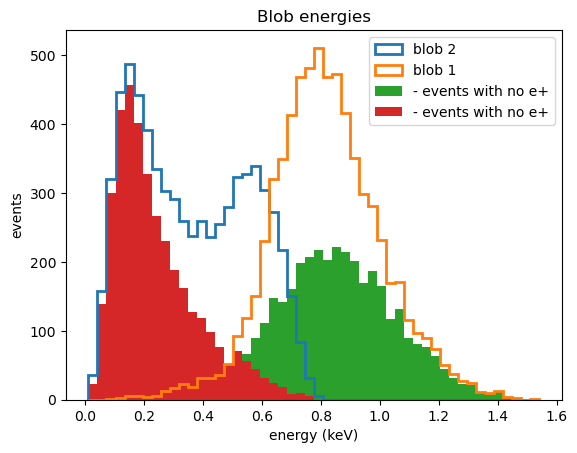

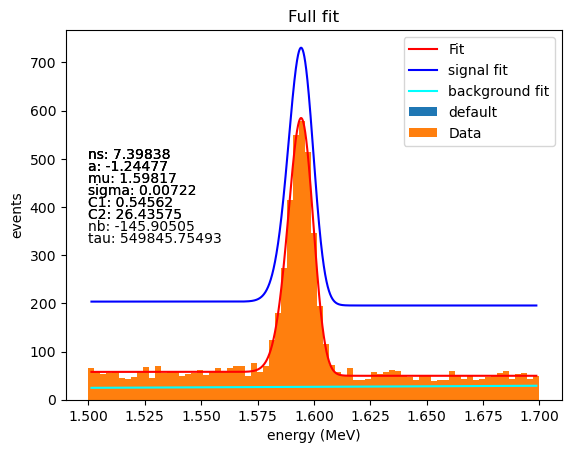

        Fitting output      
ns: 7.3984 ± nan
a: -1.2448 ± 0.1412
mu: 1.5982 ± 0.0002
sigma: 0.0072 ± 0.0002
C1: 0.5456 ± 0.3512
C2: 26.4357 ± nan
nb: -145.9051 ± nan
tau: 549845.7549 ± nan


/tmp/ipykernel_11038/3172978394.py:14: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


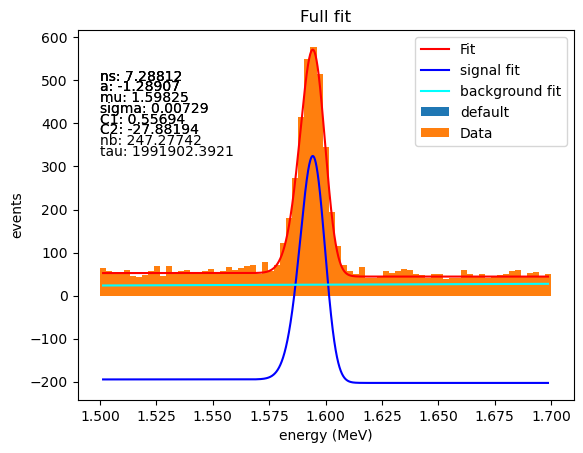

        Fitting output      
ns: 7.2881 ± 0.0843
a: -1.2891 ± 0.1590
mu: 1.5982 ± 0.0003
sigma: 0.0073 ± 0.0003
C1: 0.5569 ± 0.3500
C2: -27.8819 ± 6816938.1542
nb: 247.2774 ± 49682665.7128
tau: 1991902.3921 ± 715142601669.5918


/tmp/ipykernel_11038/112811124.py:77: RuntimeWarning: invalid value encountered in sqrt
  fom.append(e[i]/np.sqrt(b[i]))


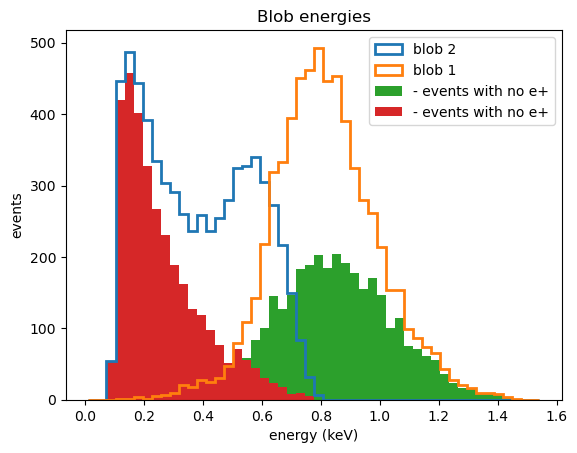

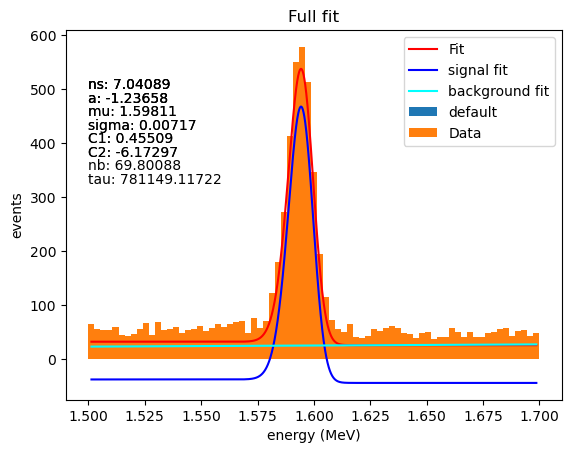

        Fitting output      
ns: 7.0409 ± 0.0750
a: -1.2366 ± 0.1533
mu: 1.5981 ± 0.0003
sigma: 0.0072 ± 0.0003
C1: 0.4551 ± 0.3579
C2: -6.1730 ± 3619294.0423
nb: 69.8009 ± 25483062.2558
tau: 781149.1172 ± 430287634219.6452


/tmp/ipykernel_11038/112811124.py:77: RuntimeWarning: invalid value encountered in sqrt
  fom.append(e[i]/np.sqrt(b[i]))


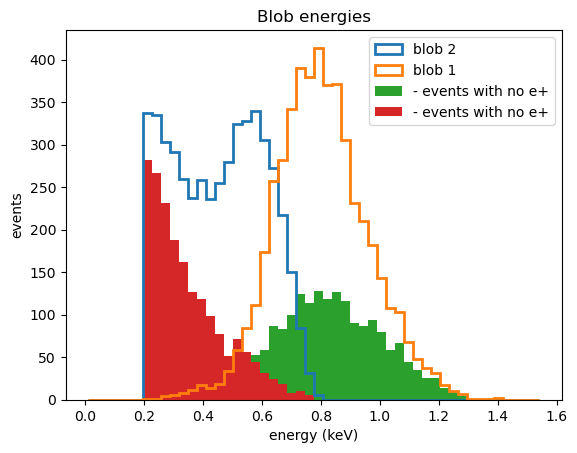

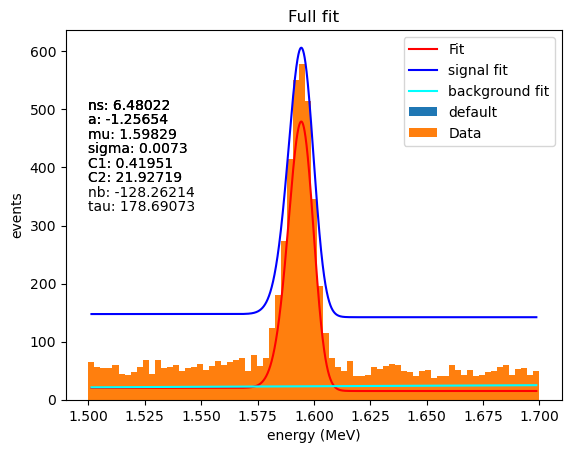

        Fitting output      
ns: 6.4802 ± 0.0672
a: -1.2565 ± 0.1278
mu: 1.5983 ± 0.0002
sigma: 0.0073 ± 0.0002
C1: 0.4195 ± 0.3039
C2: 21.9272 ± 2587751.8653
nb: -128.2621 ± 16768523.8151
tau: 178.6907 ± 23574337.5384


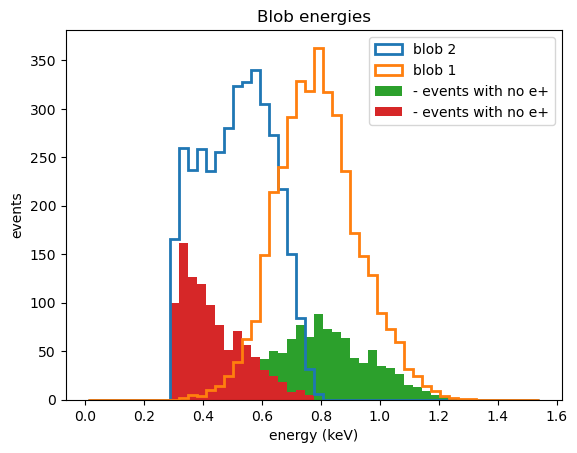

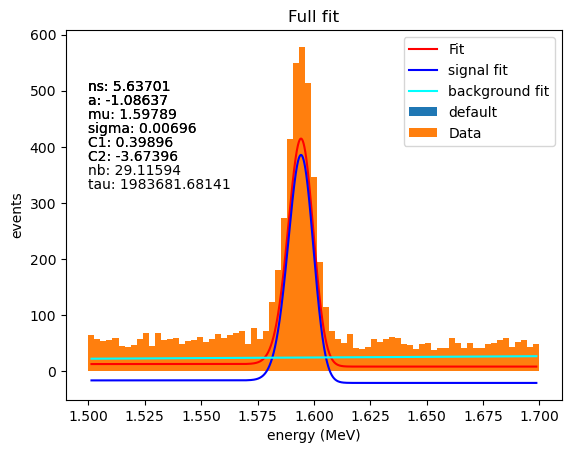

        Fitting output      
ns: 5.6370 ± 0.0560
a: -1.0864 ± 0.1326
mu: 1.5979 ± 0.0003
sigma: 0.0070 ± 0.0002
C1: 0.3990 ± 0.2170
C2: -3.6740 ± 3328363.8756
nb: 29.1159 ± 18762026.5225
tau: 1983681.6814 ± 2225098824346.3623


/tmp/ipykernel_11038/112811124.py:77: RuntimeWarning: invalid value encountered in sqrt
  fom.append(e[i]/np.sqrt(b[i]))


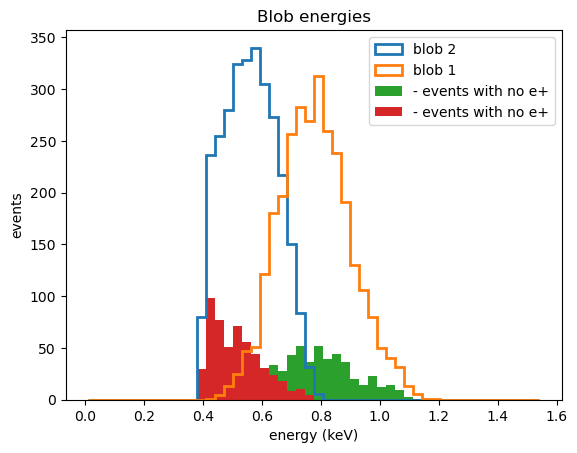

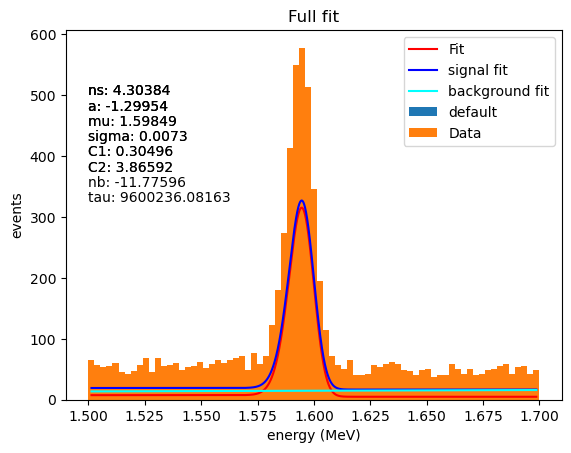

        Fitting output      
ns: 4.3038 ± 0.0456
a: -1.2995 ± 0.1486
mu: 1.5985 ± 0.0003
sigma: 0.0073 ± 0.0003
C1: 0.3050 ± 0.1367
C2: 3.8659 ± 5425958.2763
nb: -11.7760 ± 23352451.1629
tau: 9600236.0816 ± 38690557816961.8203


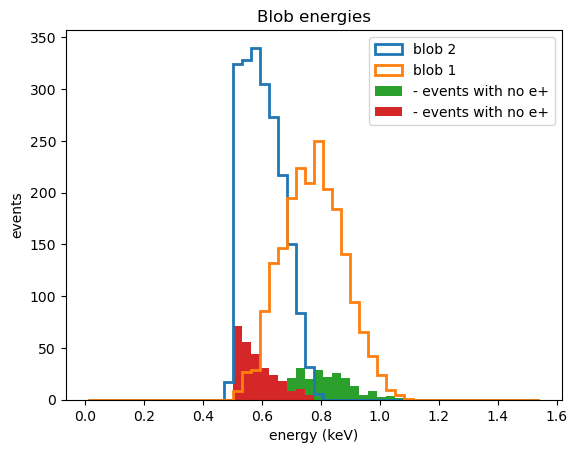

In [108]:
# creating cut list
#cut_list = np.linspace(0, 0.5, 25)

# test first
cut_list = [0.1, 0.2, 0.3, 0.4, 0.5]
print("Cut list: {}".format(cut_list))
fom = fom_calc(fitting_data, fitting_data_nopos, cut_list, verbose=True)

[nan, nan, 0.9341987399525645, nan, 2.047653196397567]
[0.         0.         0.93419874 0.         2.0476532 ]
[0.1, 0.2, 0.3, 0.4, 0.5]


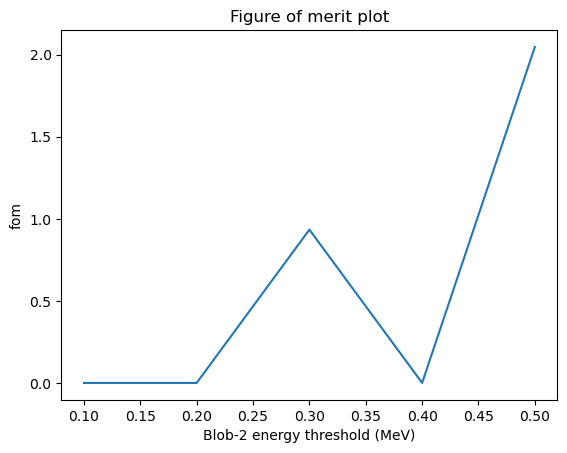

In [109]:
# kill the nans due to poor fitting 
print(fom)
fom = np.array(fom)
fom[np.isnan(fom)] = 0
print(fom)
[print(cut_list)]


# plot fom
plt.plot(cut_list, fom)
plt.title("Figure of merit plot")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

## Graveyard, all old code here

In [64]:
# adding a break in here so when you do 'run all' it stops here
break;

SyntaxError: 'break' outside loop (1414924491.py, line 2)

In [ ]:
# testing fiducial cuts

'''def gth_lth_cuts(df, column_title, one_sided = False, lower_lim = 0, upper_lim = 0, absolute = True):
    #applies cut on column via upper and lower limits (greater than, lesser than)
    #column title for two sided should be a tuple!

    # double sided
    if (one_sided==False):
        # conditional absolute for fiducial case, so include negative values within this range.
        if (absolute == True):
            filt_df = df[(abs(df[column_title[0]]) >= lower_lim) & (abs(df[column_title[1]]) <= upper_lim)]
        else:
            filt_df = df[(df[column_title[0]] >= lower_lim) & (df[column_title[1]] <= upper_lim)]
    # one sided (lower or upper limit)
    else:
        # set greater or lesser based on lower or upper limit being 0
        print("placeholder")
'''
'''
def fiducial_track_cut(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    
    # Bespoke cutting algorithm for NEXT100 isaura which cuts for fiducial volume
    # z is contrained in a two-sided fashion (greater and less than), while R is taken not treated is one-sided.
    
    # create list of events that are outside the fiducial area
    z_df = df[(df['z_min'] <= lower_z) & (df['z_max'] >= upper_z)]
    rz_df = z_df[(z_df['r_max'] >= r_lim)]
    print(rz_df['event'])


    # z filtering
    filt_z_df = df[(df['z_min'] >= lower_z) & (df['z_max'] <= upper_z)] # mm

    # r filtering
    filt_df = filt_z_df[(filt_z_df['r_max'] <= r_lim)]

    # these two create masks, then you need to collect the events to preserve based on this.

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))

    return filt_df
'''


lower_z = 20
upper_z = 1195
r_lim = 472
# create list of events that are outside the fiducial area
z_df_low = tracks[(tracks['z_min'] <= lower_z)]
z_df_up = tracks[(tracks['z_max'] >= upper_z)]
r_df = tracks[(tracks['r_max'] >= r_lim)]
# printing it for understanding
display(z_df_low['event'].to_numpy()[:10])
# the numpy lists of events that need to be removed
df_low_list = (z_df_low['event'].to_numpy())
df_up_list = (z_df_up['event'].to_numpy())
r_list = (r_df['event'].to_numpy())

# then removing all events with these event numbers, lets start with event 112
display(tracks[:103])
# so you can see track 112 has z_min below lower_z
# all rows with event = 112 needs to go here.
remover = tracks[~tracks['event'].isin(df_low_list)]
display(remover[:103]) # does work!

#so lets functionalise this!




#### An aside, looking at the event chains